In [1]:
# imports

import os
import re
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
from items import Item
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from openai import OpenAI
from anthropic import Anthropic
# tester function
from testing import Tester

In [2]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [3]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [4]:
openai = OpenAI()
claude = Anthropic()

In [5]:
%matplotlib inline

In [6]:
# Let's avoid curating all our data again! Load in the pickle files:

with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

train = [item for item in train if item.prompt]

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

test = [item for item in test if item.prompt]

In [7]:
# First let's work on a good prompt for a Frontier model
# Notice that I'm removing the " to the nearest dollar"
# When we train our own models, we'll need to make the problem as easy as possible, 
# but a Frontier model needs no such simplification.

def messages_for(item):
    system_message = "You estimate the sentiment of financial news. Reply only with either 0 for 'bearish', 1 for 'bullish' or 2 for 'neutral'. Don't provider any explanation"
    user_prompt = item.test_prompt().replace("\n\nSentiment is","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Sentiment is"}
    ]

In [8]:
# Try this out

messages_for(test[0])

[{'role': 'system',
  'content': "You estimate the sentiment of financial news. Reply only with either 0 for 'bearish', 1 for 'bullish' or 2 for 'neutral'. Don't provider any explanation"},
 {'role': 'user',
  'content': 'What is the financial sentiment of this tweet?\n\n$DELL $HPE - Dell, HPE targets trimmed on compute headwinds https '},
 {'role': 'assistant', 'content': 'Sentiment is'}]

In [9]:
# A utility function to extract the label from a string

def get_label(s):
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 2

In [10]:
get_label("The sentiment is 2 because blah blah")

2.0

In [11]:
# The function for gpt-4o-mini

def gpt_4o_mini(item):
    response = openai.chat.completions.create(
        model="gpt-4o-mini", 
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_label(reply)

In [12]:
test[0].label

0

1: Guess=0.0 Truth=0 Item: $DELL $HPE - Dell, HPE targets trimmed o...
2: Guess=0.0 Truth=0 Item: $PRTY - Moody's turns negative on Party ...
3: Guess=0.0 Truth=0 Item: $TAP - Barclays cools on Molson Coors ht...
4: Guess=0.0 Truth=0 Item: Analysts Eviscerate Musk's Cybertruck: "...
5: Guess=0.0 Truth=0 Item: Barclays assigns only a 20% chance that ...
6: Guess=0.0 Truth=0 Item: BTIG points to breakfast pressure for Du...
7: Guess=0.0 Truth=0 Item: Children's Place downgraded to neutral f...
8: Guess=0.0 Truth=0 Item: Clovis Oncology downgraded to in line fr...
9: Guess=0.0 Truth=0 Item: Downgrades 4/7: $AAN $BDN $BECN $BTE $CD...
10: Guess=0.0 Truth=0 Item: Goldman pulls Progressive from Goldman's...
11: Guess=0.0 Truth=0 Item: Hanesbrands downgraded to underperform v...
12: Guess=0.0 Truth=0 Item: LendingTree price target cut to $350 fro...
13: Guess=0.0 Truth=0 Item: Mizuho cuts XLNX target on near-term hea...
14: Guess=0.0 Truth=0 Item: MPLX cut at Credit Suisse on potential d...
1

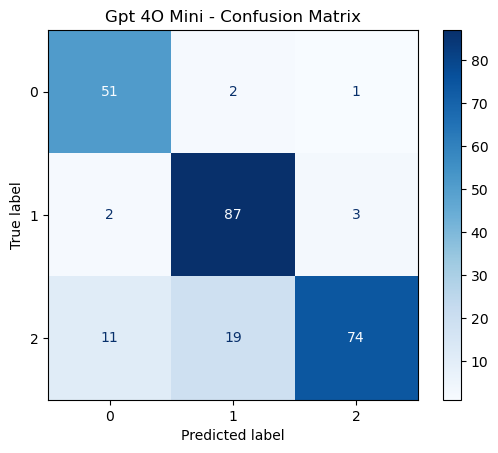

In [13]:
Tester.test(gpt_4o_mini, test)

In [14]:
def claude_3_point_5_sonnet(item):
    messages = messages_for(item)
    system_message = messages[0]['content']
    messages = messages[1:]
    response = claude.messages.create(
        model="claude-3-5-sonnet-20240620",
        max_tokens=5,
        system=system_message,
        messages=messages
    )
    reply = response.content[0].text
    return get_label(reply)

/var/folders/f7/kbrclqjn33q4srn7lth6dx_00000gn/T/ipykernel_22953/2502733124.py:5: DeprecationWarning: The model 'claude-3-5-sonnet-20240620' is deprecated and will reach end-of-life on October 22, 2025.
Please migrate to a newer model. Visit https://docs.anthropic.com/en/docs/resources/model-deprecations for more information.
  response = claude.messages.create(


1: Guess=0.0 Truth=0 Item: $DELL $HPE - Dell, HPE targets trimmed o...
2: Guess=2 Truth=0 Item: $PRTY - Moody's turns negative on Party ...
3: Guess=0.0 Truth=0 Item: $TAP - Barclays cools on Molson Coors ht...
4: Guess=2 Truth=0 Item: Analysts Eviscerate Musk's Cybertruck: "...
5: Guess=0.0 Truth=0 Item: Barclays assigns only a 20% chance that ...
6: Guess=0.0 Truth=0 Item: BTIG points to breakfast pressure for Du...
7: Guess=2 Truth=0 Item: Children's Place downgraded to neutral f...
8: Guess=2 Truth=0 Item: Clovis Oncology downgraded to in line fr...
9: Guess=0.0 Truth=0 Item: Downgrades 4/7: $AAN $BDN $BECN $BTE $CD...
10: Guess=0.0 Truth=0 Item: Goldman pulls Progressive from Goldman's...
11: Guess=0.0 Truth=0 Item: Hanesbrands downgraded to underperform v...
12: Guess=0.0 Truth=0 Item: LendingTree price target cut to $350 fro...
13: Guess=2 Truth=0 Item: Mizuho cuts XLNX target on near-term hea...
14: Guess=2 Truth=0 Item: MPLX cut at Credit Suisse on potential d...
15: Guess=2 T

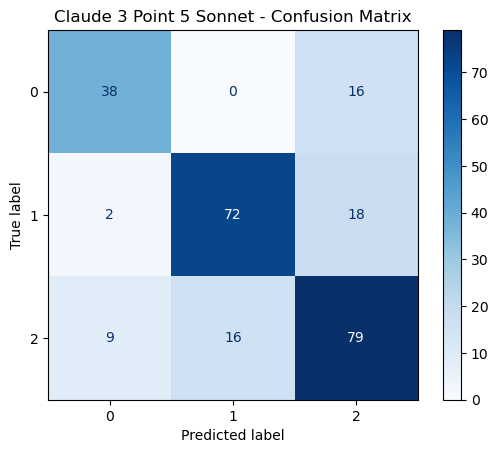

In [15]:
Tester.test(claude_3_point_5_sonnet, test)